<a href="https://colab.research.google.com/github/gizdatalab/CPU_Tracs/blob/main/notebooks/IKI_SECTOR_Setfit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

SETFIT Ver 1.0.1:  


*   [How-to Guide](https://huggingface.co/docs/setfit/how_to/overview)
*   [Sampling Strategies](https://huggingface.co/docs/setfit/conceptual_guides/sampling_strategies)
*   [Setfit Conceptual Guide](https://huggingface.co/docs/setfit/conceptual_guides/setfit)

In [ ]:
!pip install sentence-transformers==2.3.1
!pip install setfit==1.0.3

# !pip install datasets==2.3.0
# !pip install scikit-multilearn
# # !pip install optuna
# !pip install umap-learn hdbscan
# !pip install codecarbon

In [ ]:
import datasets
import pandas as pd
import ast
import numpy as np
from typing import Dict, List, Optional, Set, Tuple, Union, Literal
from setfit import TrainingArguments
from setfit import Trainer
from transformers.trainer_callback import (
    CallbackHandler,
    DefaultFlowCallback,
    IntervalStrategy,
    PrinterCallback,
    ProgressCallback,
    TrainerCallback,
    TrainerControl,
    TrainerState,
)
from setfit import SetFitModel, TrainingArguments

from sentence_transformers import SentenceTransformer, InputExample, losses, models
from sentence_transformers.losses.BatchHardTripletLoss import \
    BatchHardTripletLossDistanceFunction

from skmultilearn.model_selection import iterative_train_test_split
from skmultilearn.model_selection import IterativeStratification
import torch
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from setfit import SetFitModel
# to set the device type, if using GPU
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
import os
import umap.umap_ as umap
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
import setfit
setfit.__version__

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


'1.0.3'

In [ ]:
from codecarbon import EmissionsTracker

tracker = EmissionsTracker()
tracker.start()

In [ ]:
# we use the original dataset for the sectors we need to focus
repo_id = "GIZ/policy_classification"
filename="policy_classification.json"
from huggingface_hub import hf_hub_download
hf_hub_download(repo_id, filename=filename,
                repo_type="dataset",use_auth_token=True,
local_dir= 'data/')
data = pd.read_json('data/policy_classification.json')
data = data[data.Language == 'en']
data = data[data.SectorLabel.notna()]
# for IKI-Tracs only these sectors are important/focus
labels = ['Economy-wide','Energy','Transport']
data = data.reset_index(drop=True)
data['SectorLabel'] = data.SectorLabel.apply(lambda x:
                    list(set(['Other Sector' if i not in labels else i for i in x])))
data['check'] = data.SectorLabel.apply(lambda x: True if ('Transport' in x) and
                                          ('Economy-wide' not in x) else False)
# we sample few examples from previous dataset
sample_df = data[data.check ==True].reset_index(drop=True).sample(n=150, random_state=42)
sample_df =sample_df[['Context','SectorLabel']].reset_index(drop=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


policy_classification.json:   0%|          | 0.00/23.8M [00:00<?, ?B/s]

In [ ]:
# reading annotated dataset
import json
path_to_folder = '/content/drive/MyDrive/Colab Notebooks/giz/IKI_Tracs/'
df = pd.read_json(path_to_folder + 'datasets/sector_mutlilabel_classification.json')
print(len(df))
# filter out validated records
df = df[df.status == 'Validated'].reset_index(drop=True)[['text','annotation']]
df = df[df.annotation.str.len() !=0].reset_index(drop=True)
# some simple data manipulation
df['annotation'] = df.annotation.apply(lambda x: ['Other Sector'
                                            if i == 'None' else i for i in x ])
df.rename(columns = {'text':'Context','annotation':'SectorLabel'}, inplace=True)
df.head()

154


,Context,SectorLabel
0,"In the northern states, rainfall varies betwee...",[Other Sector]
1,The government will put in efforts towards imp...,[Economy-wide]
2,Grenada’s 2nd National Communication to the Un...,[Other Sector]
3,Investment in energy efficiency and renewable ...,"[Energy, Economy-wide]"
4,b) Assumptions and methodological approaches u...,[Economy-wide]


In [ ]:
df = pd.concat([sample_df,df], ignore_index=True)
df.drop_duplicates(subset = ['Context'],inplace=True)
df = df.reset_index(drop=True)
df.info()
df.to_csv('sector_annotated.csv')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 292 entries, 0 to 291
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Context      292 non-null    object
 1   SectorLabel  292 non-null    object
dtypes: object(2)
memory usage: 4.7+ KB


# Manual Input Steps

In [ ]:
################ Define the important variables (Load and Process data) #######

# path to data folder
data_folder = '/content/'
file_name = 'sector_annotated.csv'

# Map the columns which need to be processesed. i.e column which contains 'text' for
# prediciton and label column  for ground truth.
text_column = 'Context'
label_column = 'SectorLabel'

# train-test split
test_size=0.15


############# Define the Parameters for the Model to be used ##################

# Model to be used for Sentence Embedding
model_id = "ppsingh/SECTOR-multilabel-mpnet_w"

# USE DENSE ( Setfit Head) or NOT, If not Scikit Learn head will be used
use_differentiable_head=True
# normalize the embedding or not
normalize_embeddings: bool = True


############## Define Training Arguments   ########################

# batch sizes and epochs for the embedding and classifier training phases
# respectively, or set both if an integer is provided. Note that the batch
# size for the classifier is only used with a differentiable PyTorch head.
batch_size= (16,2)

# we keep the epochs=0 for classiifier stage as we will do the Classifier Trianing
# on our own using separate method, this is done to insure the we have control
# over the classifier trianing phase and look at metrics to guage if
# overfitting or underfititng
num_epochs = (1,0)


# we need it for our own custom Classifier training
classifier_num_epochs = 10


# for multi-class and multilabel dataset we will usually
# have positive class in minority there fore maybe a good
# option to try, rather than model getting focused too much
# on negative class.
# [''oversampling'.'undersampling, 'unique'], Default = 'oversampling'
sampling_strategy = 'oversampling'

# Set the learning rate for the SentenceTransformer body for the embedding and
# classifier training phases respectively, or set both if a float is provided.
# Note that the body learning rate for the classifier is only used with a
# differentiable PyTorch head and if end_to_end=True.
body_learning_rate = (0.00002, 0.00001)
head_learning_rate = 0.01


loss = losses.CosineSimilarityLoss

# to be used only for triplet loss categories
# distance_metric = losses.BatchHardTripletLossDistanceFunction.cosine_distance,

#  log and evlautions strategy and steps
# Strategy possible vlaues: ["steps","epochs","no"]
logging_strategy = "steps"
evaluation_strategy = "steps"
logging_steps = 200
eval_steps=200

# # to be used for triplet loss category
# margin = 0.25

## to be used with differential head
end_to_end = False
# if use_differentiable_head == True:
#     end_to_end = True
# else: end_to_end = False

warmup_proportion = 0.01

## to be used for triplet loss only
# samples_per_label = 2

# output dir, if you push the mdoel to hub then this will be name of model
output_dir = "setfit-multilabel"


# method to use for embedding dimentionality reduction
method = 'umap'

# Automated

## Load & Sample Data

In [ ]:
import pandas as pd
import ast
import numpy as np
from skmultilearn.model_selection import iterative_train_test_split
from skmultilearn.model_selection import IterativeStratification

In [ ]:
df = pd.read_csv(data_folder + file_name, index_col=0)

# when reading csv the label if in form of dict/list will get converted to str
# tehrefore we convert it back to dict/list
if type(df.loc[0,label_column]) != list:
    df[label_column] = df[label_column].apply(lambda x: ast.literal_eval(x))

# get the categories or labels information
temp = list(df[label_column])
label_names = list(set([item for sublist in temp for item in sublist]))
label_names.sort()
num_labels = len(label_names)
id2label = {idx:label for idx, label in enumerate(label_names)}
label2id = {label:idx for idx, label in enumerate(label_names)}
print("Label Mapping",'\n')
for key,val in label2id.items(): print(key,":",val)

# create one-hot-encoded labels
df['multi'+label_column] = df[label_column].apply(lambda x: [1 if i in x  else 0
                                                            for i in label_names])

Label Mapping 

Economy-wide : 0
Energy : 1
Other Sector : 2
Transport : 3


In [ ]:
# Divide the dataset into train and test dataset (using multilabel stratifier)

# Convert 'label' column to a list of lists
X = df[text_column].tolist()
X = [[x] for x in X]
y = df['multi'+label_column].tolist()
y = np.array(y)
X = np.array(X)

# Create train and test
X_train, y_train, X_test, y_test = iterative_train_test_split(X, y, test_size=test_size)

# Turn arrays back into list
X_train = X_train.tolist()
y_train = y_train.tolist()
X_test = X_test.tolist()
y_test = y_test.tolist()

# Create train and test df
df_test = pd.DataFrame({'text': X_test, 'label': y_test})
df_train = pd.DataFrame({'text': X_train, 'label': y_train})

# Remove the list
df_train['text'] = df_train['text'].apply(lambda x: x[0])
df_test['text'] = df_test['text'].apply(lambda x: x[0])

print('\n','Classes Representation after stratification', "Training data:",len(df_train))
for i,label in enumerate(label_names):
    print(i,".",label, ":", sum( [x[i] for x in list(df_train['label'])]))

print('\n','Classes Representation after stratification', "Test data:",len(df_test))
for i,label in enumerate(label_names):
    print(i,".",label, ":", sum( [x[i] for x in list(df_test['label'])]))


 Classes Representation after stratification Training data: 250
0 . Economy-wide : 88
1 . Energy : 63
2 . Other Sector : 64
3 . Transport : 139

 Classes Representation after stratification Test data: 42
0 . Economy-wide : 15
1 . Energy : 11
2 . Other Sector : 11
3 . Transport : 24


In [ ]:
df_train.head()

,text,label
0,Enhance maintenance and inspection of vehicle ...,"[0, 0, 0, 1]"
1,"""As part of the transformation towards sustain...","[0, 0, 0, 1]"
2,"In the CND 2020, several actions for the imple...","[0, 1, 0, 1]"
3,"""Under the aegis of the Physical Development P...","[0, 0, 0, 1]"
4,"Reducing energy use, improving energy efficien...","[0, 1, 1, 1]"


In [ ]:
# for the embedding visulization we need to have (text,single label) pair, for this we
# we explode the dataframe for labels, by attaching new entry of duplicate text
# entry for each label
# Ex: text = "I dont know what I am doing", labels = [1,0,0,1]
# text1 = "I dont know what I am doing", categorical_label = 0
# text2 = "I dont know what I am doing", categorical_label = 3
# as you can see the text has been repeated and single categorical label has been
# applied to it two times. As the labels at index 0 and 3 are only True therefore
# we have new categorical label  for duplicated text as 0 and 3.


def prepare_categorical_multilabel(df):
    # make the copy of dataframe
    df = df.copy()
    # adding the new column which will have the label as category
    # Ex: originally labels were
    df['categorical_label'] = df.label.apply(lambda x: [i*j for i,j in enumerate(x) if j==1])
    df = df.explode('categorical_label')
    df = df.reset_index(drop=True)
    # we add the labels as text also just in case we need it later
    df['label_text'] = df.categorical_label.apply(lambda x: id2label[x])

    return df

df_train_explode = prepare_categorical_multilabel(df_train)
print("Training data after explode:", len(df_train_explode))
df_test_explode = prepare_categorical_multilabel(df_test)
print("Test data after explode:", len(df_test_explode))

Training data after explode: 354
Test data after explode: 61


In [ ]:
#
train_ds = datasets.Dataset.from_pandas(df_train)
test_ds = datasets.Dataset.from_pandas(df_test)

## Metrics

https://towardsdatascience.com/evaluating-multi-label-classifiers-a31be83da6ea

In [ ]:
import evaluate
multilabel_accuracy_metric = evaluate.load("accuracy", "multilabel")
multilabel_f1_metric = evaluate.load("f1", "multilabel")
multilabel_recall_metric = evaluate.load("recall","multilabel")
multilabel_precision_metric = evaluate.load("precision","multilabel")

In [ ]:
# DONT USE ACCURACY FOR MULTILABEL, EVALUATE DOESNT SUPPORT AVERAGE STRATEGY FOR ACCURACY
multilabel_accuracy_metric.compute(references=[[0,0,1],[0, 1, 1],[1,1,0],[1,0,1]], predictions=[[1,0,1],[1, 1, 1],[1,0,0],[1,0,1]])

{'accuracy': 0.25}

In [ ]:
def compute_metrics(y_pred, y_test):
    """
    Takes the Predictions and Truth Values, and return multilabel metrics
    aggregated on multiple strategies['micro', 'sample', 'weighted']

    """

    return {
        "precision-micro": multilabel_precision_metric.compute(predictions=y_pred, references=y_test, average="micro")["precision"],
        "precision-samples": multilabel_precision_metric.compute(predictions=y_pred, references=y_test, average="samples")["precision"],
        "precision-weighted": multilabel_precision_metric.compute(predictions=y_pred, references=y_test, average="weighted")["precision"],
        "recall-micro": multilabel_recall_metric.compute(predictions=y_pred, references=y_test, average="micro")["recall"],
        "recall-samples": multilabel_recall_metric.compute(predictions=y_pred, references=y_test, average="samples")["recall"],
        "recall-weighted": multilabel_recall_metric.compute(predictions=y_pred, references=y_test, average="weighted")["recall"],
        "f1-micro": multilabel_f1_metric.compute(predictions=y_pred, references=y_test, average="micro")["f1"],
        "f1-samples": multilabel_f1_metric.compute(predictions=y_pred, references=y_test, average="samples")["f1"],
        "f1-weighted": multilabel_f1_metric.compute(predictions=y_pred, references=y_test, average="weighted")["f1"],
    }

## Model

In [ ]:
if use_differentiable_head == True:
    model = SetFitModel.from_pretrained(
                      model_id,
                      multi_target_strategy="one-vs-rest",labels = label_names,
                      device= device,
                      normalize_embeddings = normalize_embeddings,
                      use_differentiable_head=use_differentiable_head,
                      head_params={"out_features": num_labels})
else:
    model = SetFitModel.from_pretrained(
              model_id,
              multi_target_strategy="one-vs-rest", device= device,
              normalize_embeddings = normalize_embeddings,
              labels = label_names)

config.json:   0%|          | 0.00/1.56k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

Some weights of MPNetModel were not initialized from the model checkpoint at ppsingh/SECTOR-multilabel-mpnet_w and are newly initialized: ['mpnet.pooler.dense.bias', 'mpnet.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/1.63k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/962 [00:00<?, ?B/s]

model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


## Training Arguments

In [ ]:
args = TrainingArguments(
    output_dir = output_dir,
    batch_size = batch_size,
    num_epochs = num_epochs,
    sampling_strategy = sampling_strategy,
    body_learning_rate = body_learning_rate,
    head_learning_rate = head_learning_rate,
    loss = loss,
    end_to_end = end_to_end,
    warmup_proportion = warmup_proportion,
    logging_strategy=logging_strategy,
    logging_steps = logging_steps,
    eval_steps=eval_steps,
    evaluation_strategy = evaluation_strategy,
)

## Callbacks

In [ ]:
def umap_embed(embeddings, n_neighbors = 15, n_dim = 2, eval_embeddings = None):
    """
    Method to use UMAP to compress the embeddings into n_dim dimensions

    """
    umap_model = (umap.UMAP(n_neighbors=n_neighbors,
                                n_components=n_dim,
                                metric='cosine',
                                random_state=42))
    train_embed = umap_model.fit_transform(embeddings.cpu())

    train_umap = pd.DataFrame()
    for i in range(n_dim):
        train_umap[f'dim_{i+1}'] = train_embed[:,i]
    if eval_embeddings is not None:
        eval_embed = umap_model.transform(eval_embeddings.cpu())
        eval_umap = pd.DataFrame()
        for i in range(n_dim):
            eval_umap[f'dim_{i+1}'] = eval_embed[:,i]

        return train_umap, eval_umap
    return train_umap, None


def tnse_embed(train_embeddings,n_neighbors = 15, n_dim = 2):
    """
    Method to use TSNE to compress the embeddings into n_dim dimensions
    ####### NOTE Why not FIT_TRansform  ################

    """

    train_embed = TSNE(n_components=n_dim, perplexity=n_neighbors,
                   random_state=42).fit_transform(train_embeddings.cpu())
    train_tnse = pd.DataFrame()
    for i in range(n_dim):
        train_tnse[f'dim_{i+1}'] = train_embed[:,i]

    return train_tnse


def plot_embeddings_plotly(model:SetFitModel,train_data, n_neighbors,
                           method:Literal["tnse", "umap"] = "tnse",
                           eval_data=None, n_dim = 3):
    """
    given the text data, it uses the model to find the embeddings of text data,
    then compresses them to n_dim and makes the plot using plotly. You can pass
    just training data or train and val data for comparison

    """
    train_embeddings = model.encode(train_data["text"])
    if method  == 'tnse':
        scatter_df = tnse_embed(train_embeddings, n_neighbors,n_dim)
        scatter_df['labels'] = list(train_data['label_text'])
        scatter_df['type'] = "Training Embeddings"
        if eval_data is not None:
            eval_embeddings = model.encode(eval_data["text"])
            eval_scatter_df = tnse_embed(eval_embeddings,n_neighbors,n_dim)
            eval_scatter_df['labels'] = list(eval_data['label_text'])
            eval_scatter_df['type'] = "Validation Embeddings"
            scatter_df = pd.concat([scatter_df,eval_scatter_df],ignore_index=True)

    if method  == 'umap':
        if eval_data is not None:
            eval_embeddings = model.encode(eval_data["text"])
            scatter_df, eval_scatter_df = umap_embed(train_embeddings, n_neighbors,n_dim,eval_embeddings)
            scatter_df['labels'] = list(train_data['label_text'])
            scatter_df['type'] = "Training Embeddings"
            eval_scatter_df['labels'] = list(eval_data['label_text'])
            eval_scatter_df['type'] = "Validation Embeddings"
            scatter_df = pd.concat([scatter_df,eval_scatter_df],ignore_index=True)
        else:
            scatter_df,_ = umap_embed(train_embeddings, n_neighbors,n_dim,eval_embeddings)
            scatter_df['labels'] = list(train_data['label_text'])
            scatter_df['type'] = "Training Embeddings"

    if n_dim == 3:
        fig = px.scatter_3d(
        scatter_df, x='dim_1', y='dim_2', z='dim_3',facet_col="type",
        #color_discrete_sequence=['#bbbabb'],
        color='labels',
        opacity = .5)
        fig.update_scenes(xaxis_visible=False, yaxis_visible=False,zaxis_visible=False )
        fig.update_traces(marker_size=3)
    else:
        fig = px.scatter(scatter_df, x='dim_1', y='dim_2', color = 'labels', facet_col="type")

    return fig


def plot_embeddings(model:SetFitModel,train_data, n_neighbors,
                           method:Literal["tnse", "umap"] = "tnse",
                           eval_data=None, n_dim = 2):
    """
    given the text data, it uses the model to find the embeddings of text data,
    then compresses them to n_dim and makes the plot using simple matplotlib.
    You can pass just training data or train and val data for comparison

    """
    if method not in ["tnse","umap"]:
      print("method value is wrong, excepted values are ['tnse','umap']")
      return None

    train_embeddings = model.encode(train_data["text"])
    if method  == 'tnse':
            scatter_df = tnse_embed(train_embeddings, n_neighbors,n_dim)
            scatter_df['labels'] = list(train_data['categorical_label'])
            if eval_data is not None:
                eval_embeddings = model.encode(eval_data["text"])
                eval_scatter_df = tnse_embed(eval_embeddings,n_neighbors,n_dim)
                eval_scatter_df['labels'] = list(eval_data['categorical_label'])

    if method  == 'umap':
        if eval_data is not None:
            eval_embeddings = model.encode(eval_data["text"])
            scatter_df, eval_scatter_df = umap_embed(train_embeddings, n_neighbors,n_dim,eval_embeddings)
            scatter_df['labels'] = list(train_data['categorical_label'])
            eval_scatter_df['labels'] = list(eval_data['categorical_label'])
        else:
            scatter_df,_ = umap_embed(train_embeddings, n_neighbors,n_dim,eval_embeddings)
            scatter_df['labels'] = list(train_data['categorical_label'])

    fig, (train_ax, eval_ax) = plt.subplots(ncols=1,nrows=2, figsize = (10,20))

    train_scatter  = train_ax.scatter(x= scatter_df['dim_1'],
                                      y= scatter_df['dim_2'],
                                      c=scatter_df["labels"],alpha = 0.4)
                                          # label=list(df_train_explode["categorical_label"]))
    train_ax.legend(handles=train_scatter.legend_elements(num=len(label_names))[0],
                    labels=label_names) #,loc='upper center', bbox_to_anchor=(0.5, -0.05),
                #    fancybox=True, ncol=5)
    train_ax.set_title("Training embeddings")


    eval_scatter  = eval_ax.scatter(x= eval_scatter_df['dim_1'],
                                      y= eval_scatter_df['dim_2'],
                                      c=eval_scatter_df["labels"], alpha =0.4)
    eval_ax.legend(handles=eval_scatter.legend_elements(num=len(label_names))[0],
                        labels=label_names) #,loc='upper center', bbox_to_anchor=(0.5, -0.05),
                     #   fancybox=True, ncol=5)
    eval_ax.set_title("Evaluation embeddings")
    return fig

In [ ]:
class MetricsCallback(TrainerCallback):
    """Simple Metrics call back."""
    def on_evaluate(self, args: TrainingArguments, state: TrainerState, control: TrainerControl, model: SetFitModel, metrics, **kwargs):
        val_x = df_test["text"]
        val_y = df_test["label"]

        train_x = df_train["text"]
        train_y = df_train["label"]

        y_pred_train = model.predict(train_x, use_labels=False)
        y_pred_val = model.predict(val_x, use_labels=False)

        if isinstance(y_pred_train, torch.Tensor):
            y_pred_train = y_pred_train.cpu()

        if isinstance(y_pred_val, torch.Tensor):
            y_pred_val= y_pred_val.cpu()

        train_m = compute_metrics(y_pred_train, train_y)
        val_m = compute_metrics(y_pred_val, val_y)
        print(train_m)
        print(val_m)

class EmbeddingPlotCallbackPlotly(TrainerCallback):
    """Simple embedding plotting callback that plots the embeddings of training and evaluation datasets throughout training
    using plotly ."""
    def on_evaluate(self, args: TrainingArguments, state: TrainerState, control: TrainerControl, model: SetFitModel, **kwargs):
        directory = 'embeddings_plots'
        if not os.path.exists(directory):
            os.makedirs(directory)

        fig = plot_embeddings_plotly(model,df_train_explode, num_labels,method,df_test_explode,n_dim=2)
        fig.show()
        fig.write_image(f"{directory}/step_{state.global_step}.png")

class EmbeddingPlotCallback(TrainerCallback):
    """Simple embedding plotting callback that plots the embeddings of the training and evaluation datasets throughout training."""
    def on_evaluate(self, args: TrainingArguments, state: TrainerState, control: TrainerControl, model: SetFitModel, **kwargs):
        directory = 'embeddings_plots'

        if not os.path.exists(directory):
            os.makedirs(directory)

        fig  = plot_embeddings(model,df_train_explode, num_labels,method,df_test_explode,n_dim=2)
        fig.suptitle(f"tSNE of training and evaluation embeddings at step {state.global_step} of {state.max_steps}.")
        fig.savefig(f"{directory}/step_{state.global_step}.png")
        plt.show()

## Custom Trainer

In [ ]:
from tqdm.auto import tqdm, trange
from typing import Dict, List, Optional, Set, Tuple, Union, Literal
import joblib
import numpy as np
import requests
import torch
from huggingface_hub import PyTorchModelHubMixin, hf_hub_download
from huggingface_hub.utils import validate_hf_hub_args
from sentence_transformers import SentenceTransformer, models
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multioutput import ClassifierChain, MultiOutputClassifier
from torch import nn
from torch.utils.data import DataLoader
from tqdm.auto import tqdm, trange
from transformers.utils import copy_func

metrics = {"training":[],"validation":[]}
class MultilabelTrainer(Trainer):
        def on_evaluate_(self):
            val_x = df_test["text"]
            val_y = df_test["label"]

            train_x = df_train["text"]
            train_y = df_train["label"]

            y_pred_train = self.model.predict(train_x, use_labels=False)
            y_pred_val = self.model.predict(val_x, use_labels=False)

            if isinstance(y_pred_train, torch.Tensor):
                y_pred_train = y_pred_train.cpu()

            if isinstance(y_pred_val, torch.Tensor):
                y_pred_val= y_pred_val.cpu()

            train_m = compute_metrics(y_pred_train, train_y)
            val_m = compute_metrics(y_pred_val, val_y)
            print("training metrics",'\n',train_m)
            print("eval metrics",'\n',val_m)

            metrics['training'].append(train_m)
            metrics['validation'].append(val_m)


        def train_classifier_new(
        self, x_train: List[str], y_train: Union[List[int], List[List[int]]],
        x_eval: List[str], y_eval: Union[List[int], List[List[int]]],
        args: Optional[TrainingArguments] = None, classifier_num_epochs =classifier_num_epochs
    ) -> None:
            """
            Method to perform the classifier phase: fitting a classifier head.

            Args:
                x_train (`List[str]`): A list of training sentences.
                y_train (`Union[List[int], List[List[int]]]`): A list of labels corresponding to the training sentences.
                args (`TrainingArguments`, *optional*):
                    Temporarily change the training arguments for this training call.
            """
            args = args or self.args or TrainingArguments()

            num_epochs=classifier_num_epochs
            batch_size=args.classifier_batch_size
            body_learning_rate=args.body_classifier_learning_rate
            head_learning_rate=args.head_learning_rate
            l2_weight=args.l2_weight
            max_length=args.max_length
            show_progress_bar=args.show_progress_bar
            end_to_end=args.end_to_end


            if self.model.has_differentiable_head:  # train with pyTorch
              self.model.model_body.train()
              self.model.model_head.train()
              if not end_to_end:
                  self.freeze("body")

              dataloader = self.model._prepare_dataloader(x_train, y_train, batch_size, max_length)
              criterion = self.model.model_head.get_loss_fn()
              optimizer = self.model._prepare_optimizer(head_learning_rate, body_learning_rate, l2_weight)
              scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
              for epoch_idx in trange(num_epochs, desc="Epoch", disable=not show_progress_bar):
                  print(f"Epoch Value:{epoch_idx}")
                  for batch in tqdm(dataloader, desc="Iteration", disable=not show_progress_bar, leave=False):
                      features, labels = batch
                      optimizer.zero_grad()

                      # to model's device
                      features = {k: v.to(self.model.device) for k, v in features.items()}
                      labels = labels.to(self.model.device)


                      outputs = self.model.model_body(features)
                      if self.model.normalize_embeddings:
                          outputs["sentence_embedding"] = nn.functional.normalize(
                              outputs["sentence_embedding"], p=2, dim=1
                          )
                      outputs = self.model.model_head(outputs)
                      logits = outputs["logits"]

                      loss: torch.Tensor = criterion(logits, labels)
                      loss.backward()
                      optimizer.step()

                  scheduler.step()
                  self.on_evaluate_()

              if not end_to_end:
                  self.model.unfreeze("body")
            else:  # train with sklearn
                embeddings = self.model.model_body.encode(x_train, normalize_embeddings=self.normalize_embeddings)
                self.model.model_head.fit(embeddings, y_train)

#Training

In [ ]:
# use appropriate callbacks that you want to include
trainer = MultilabelTrainer(model = model,
          args = args,
          train_dataset=train_ds,
          eval_dataset=test_ds,
          metric = compute_metrics,
          column_mapping={"text": "text", "label": "label"},
          callbacks=[EmbeddingPlotCallback()])

Applying column mapping to the training dataset
Applying column mapping to the evaluation dataset


  0%|          | 0/250 [00:00<?, ?ex/s]

## Embedding Training

***** Running training *****
  Num unique pairs = 32226
  Batch size = 16
  Num epochs = 1
  Total optimization steps = 2015


Step,Training Loss,Validation Loss,Embedding Loss,Rate
200,No log,No log,0.112400,0.000018
400,No log,No log,0.111000,0.000016
600,No log,No log,0.121400,0.000014
800,No log,No log,0.124800,0.000012
1000,No log,No log,0.133900,0.000010
1200,No log,No log,0.118100,0.000008
1400,No log,No log,0.120800,0.000006
1600,No log,No log,0.126700,0.000004
1800,No log,No log,0.125400,0.000002
2000,No log,No log,0.127100,0.000000


  0%|          | 0/59 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


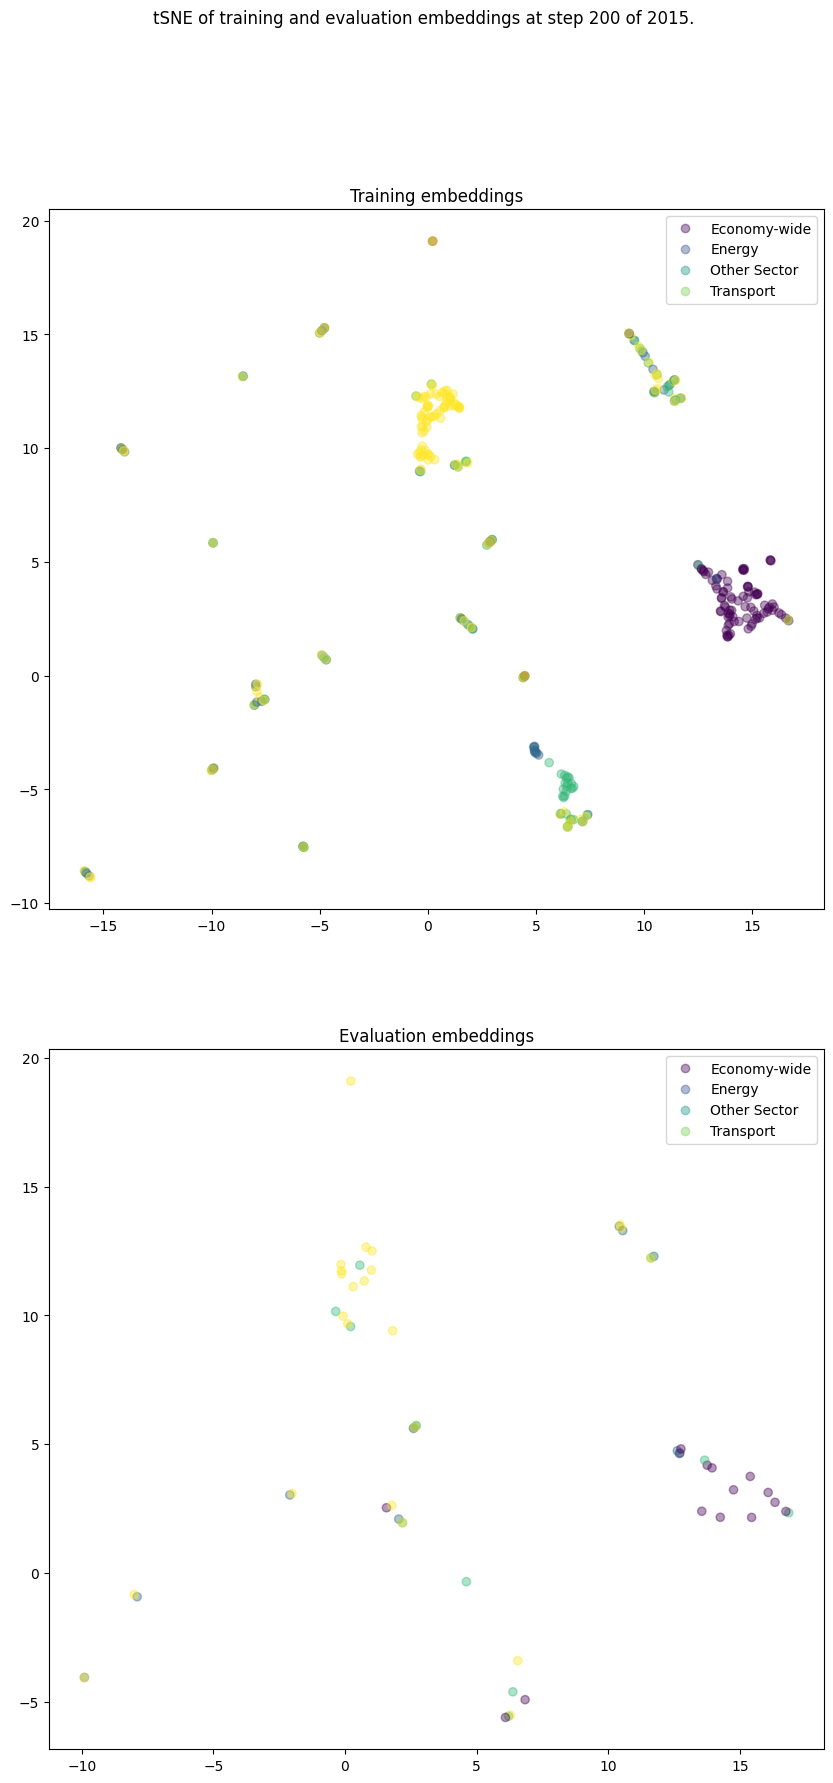

  0%|          | 0/59 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


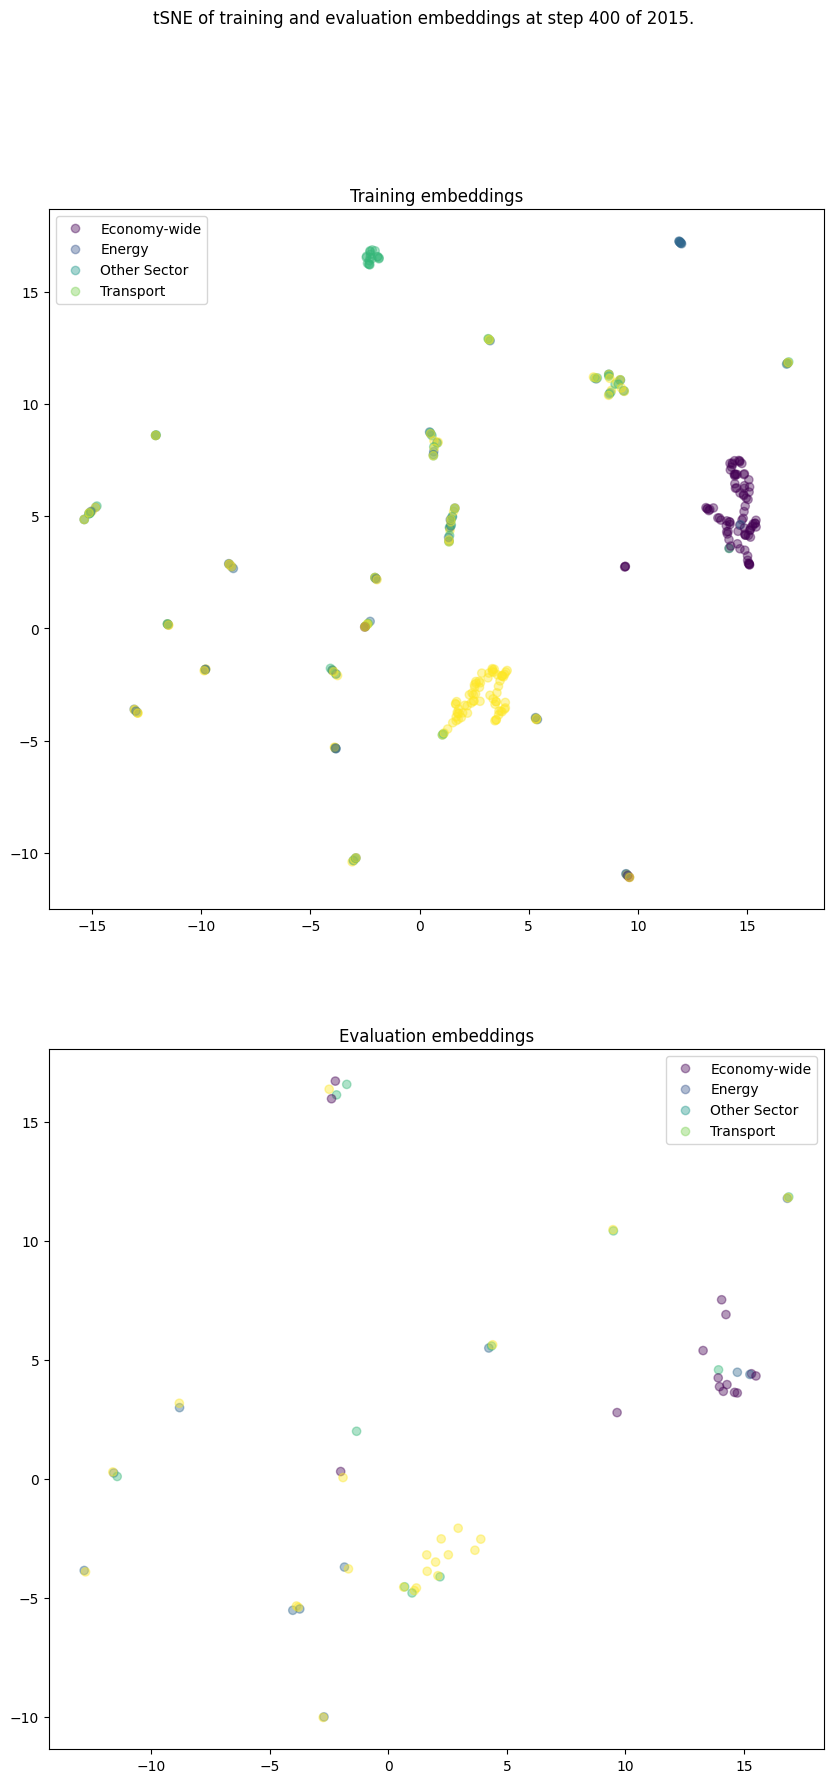

  0%|          | 0/59 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


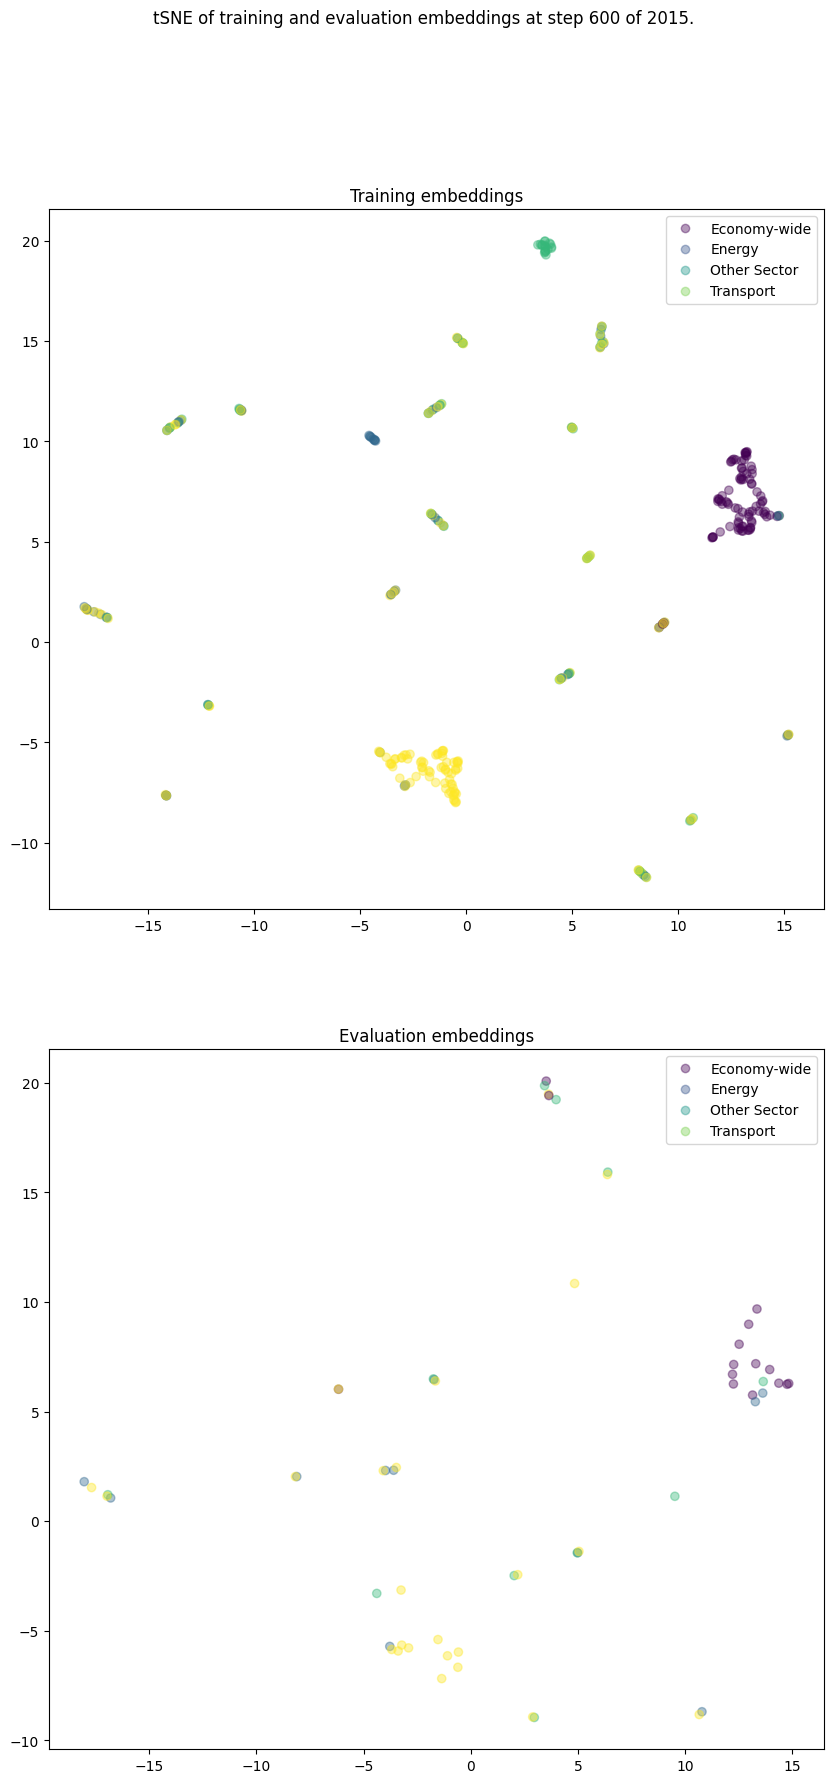

  0%|          | 0/59 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


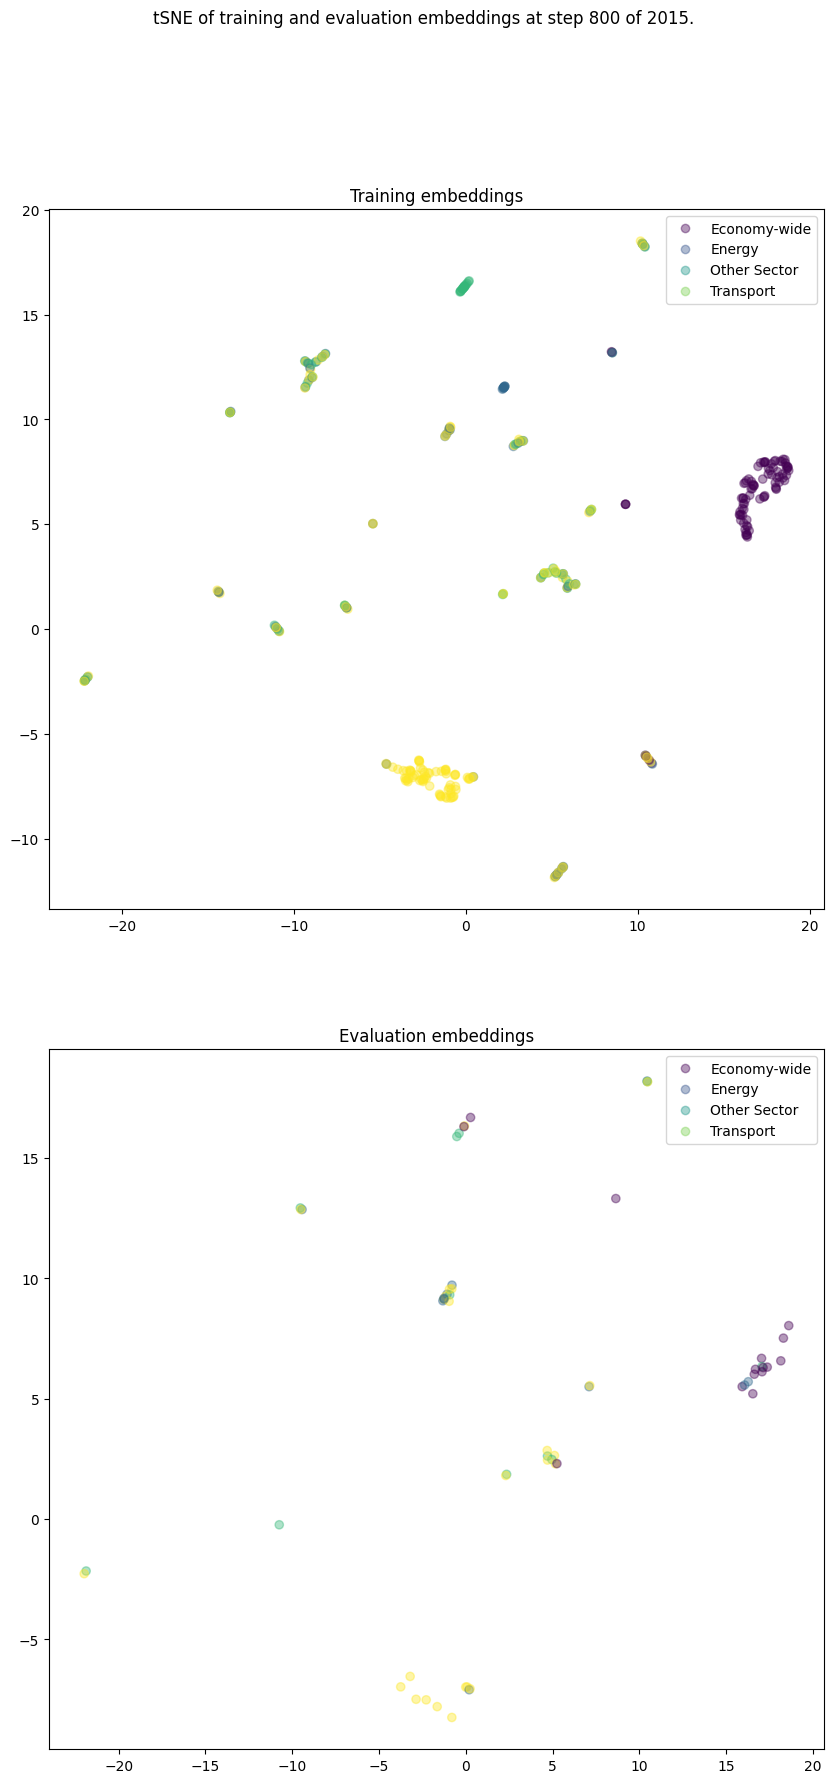

  0%|          | 0/59 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/usr/local/lib/python3.10/dist-packages/umap/spectral.py:550: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(


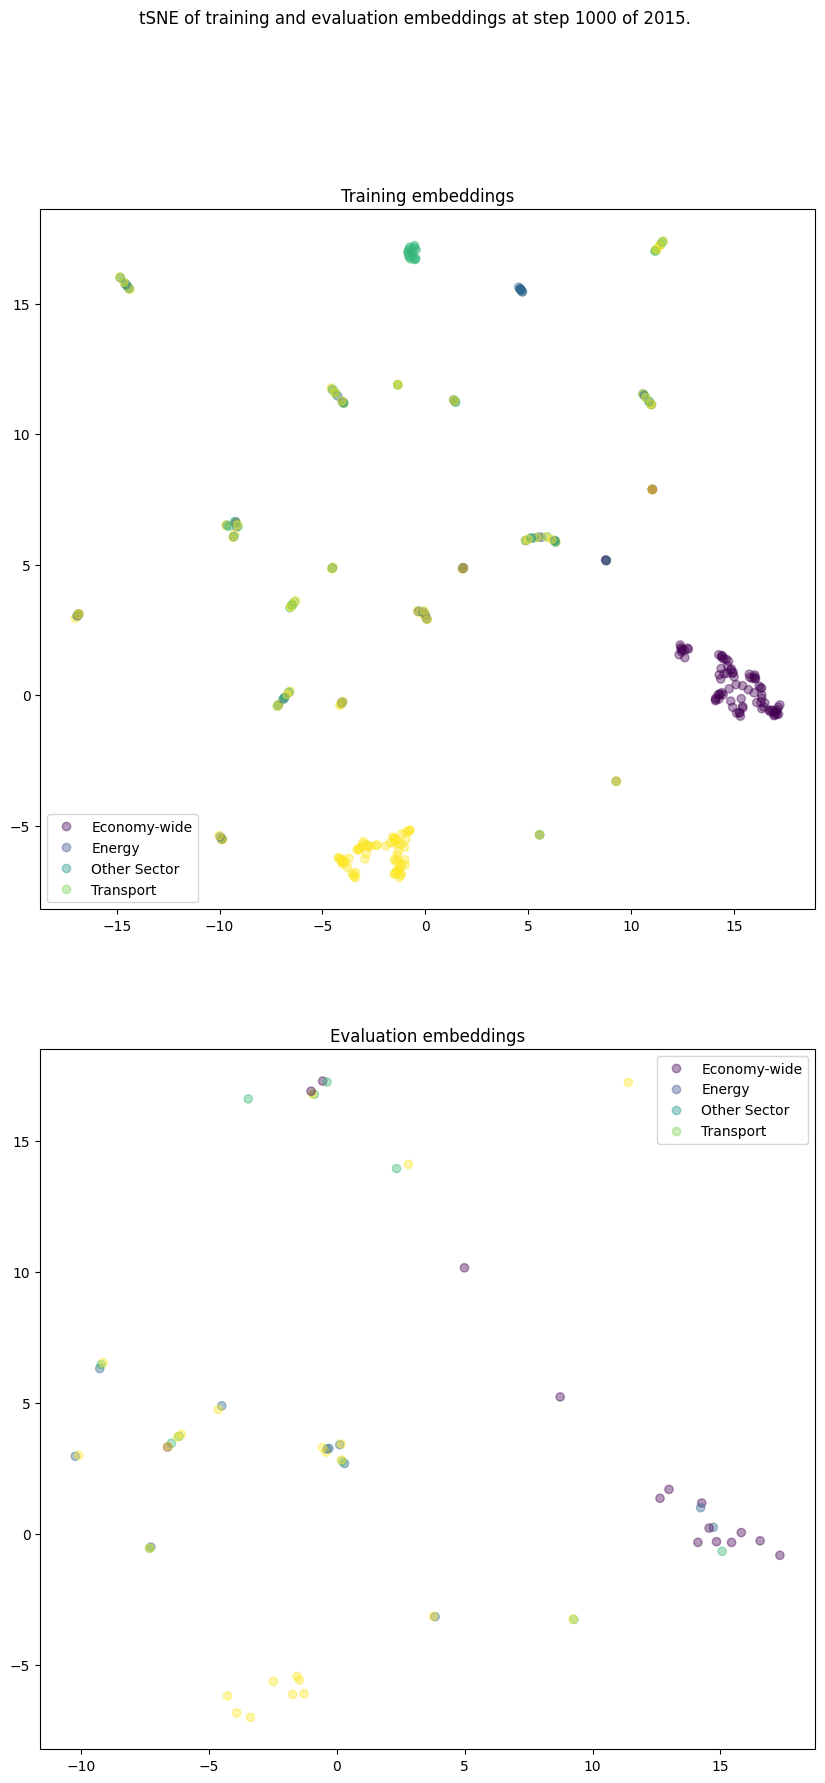

  0%|          | 0/59 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


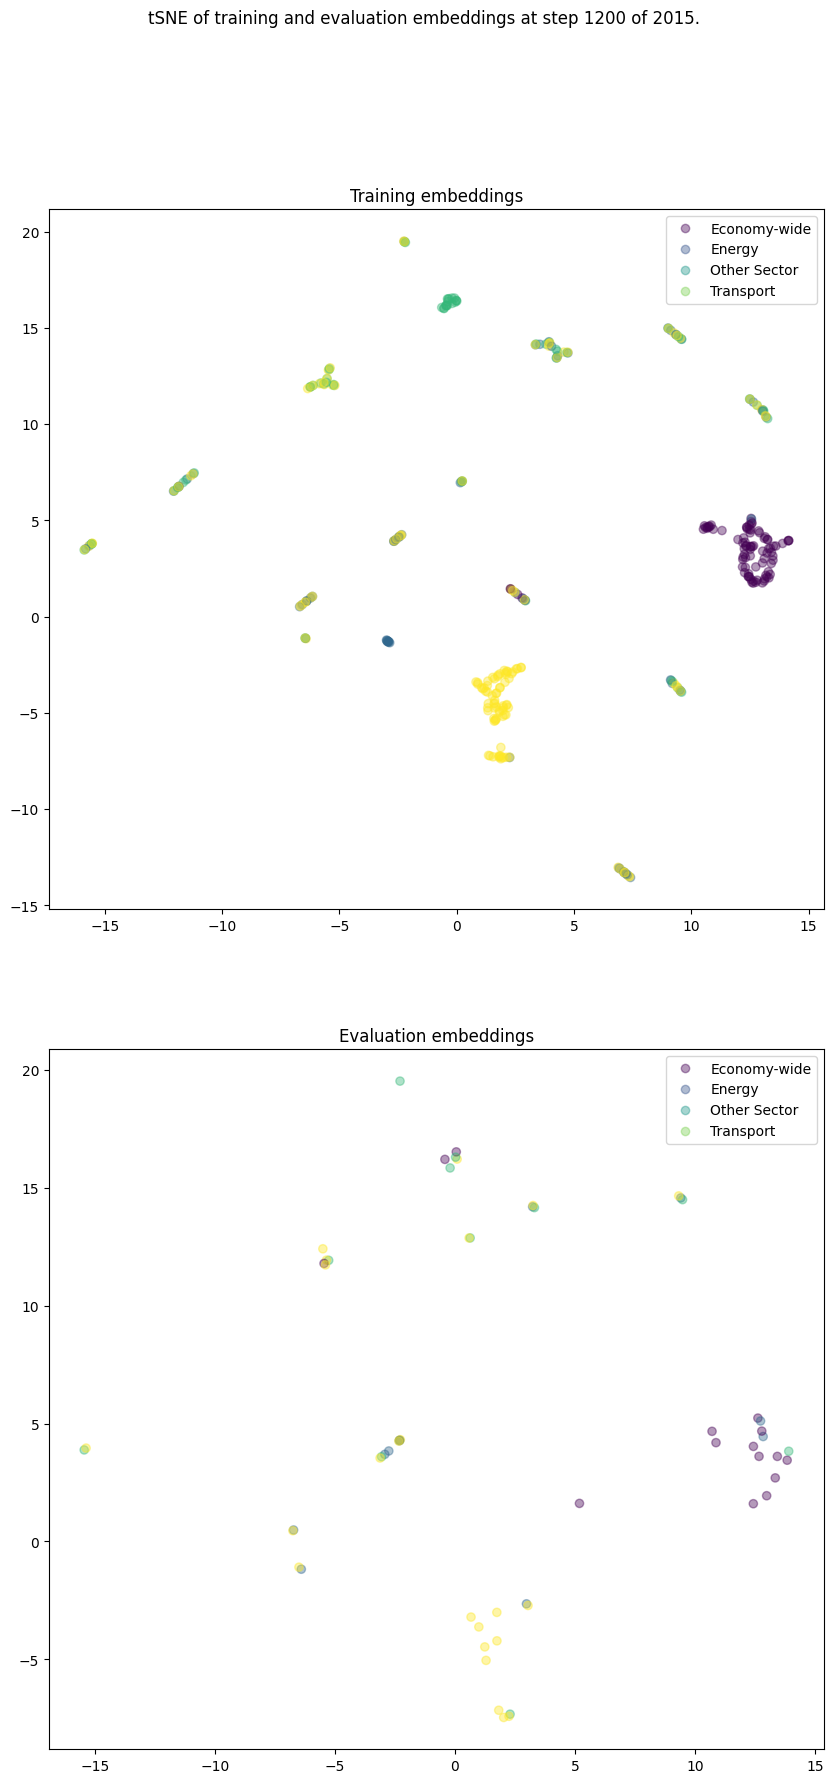

  0%|          | 0/59 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


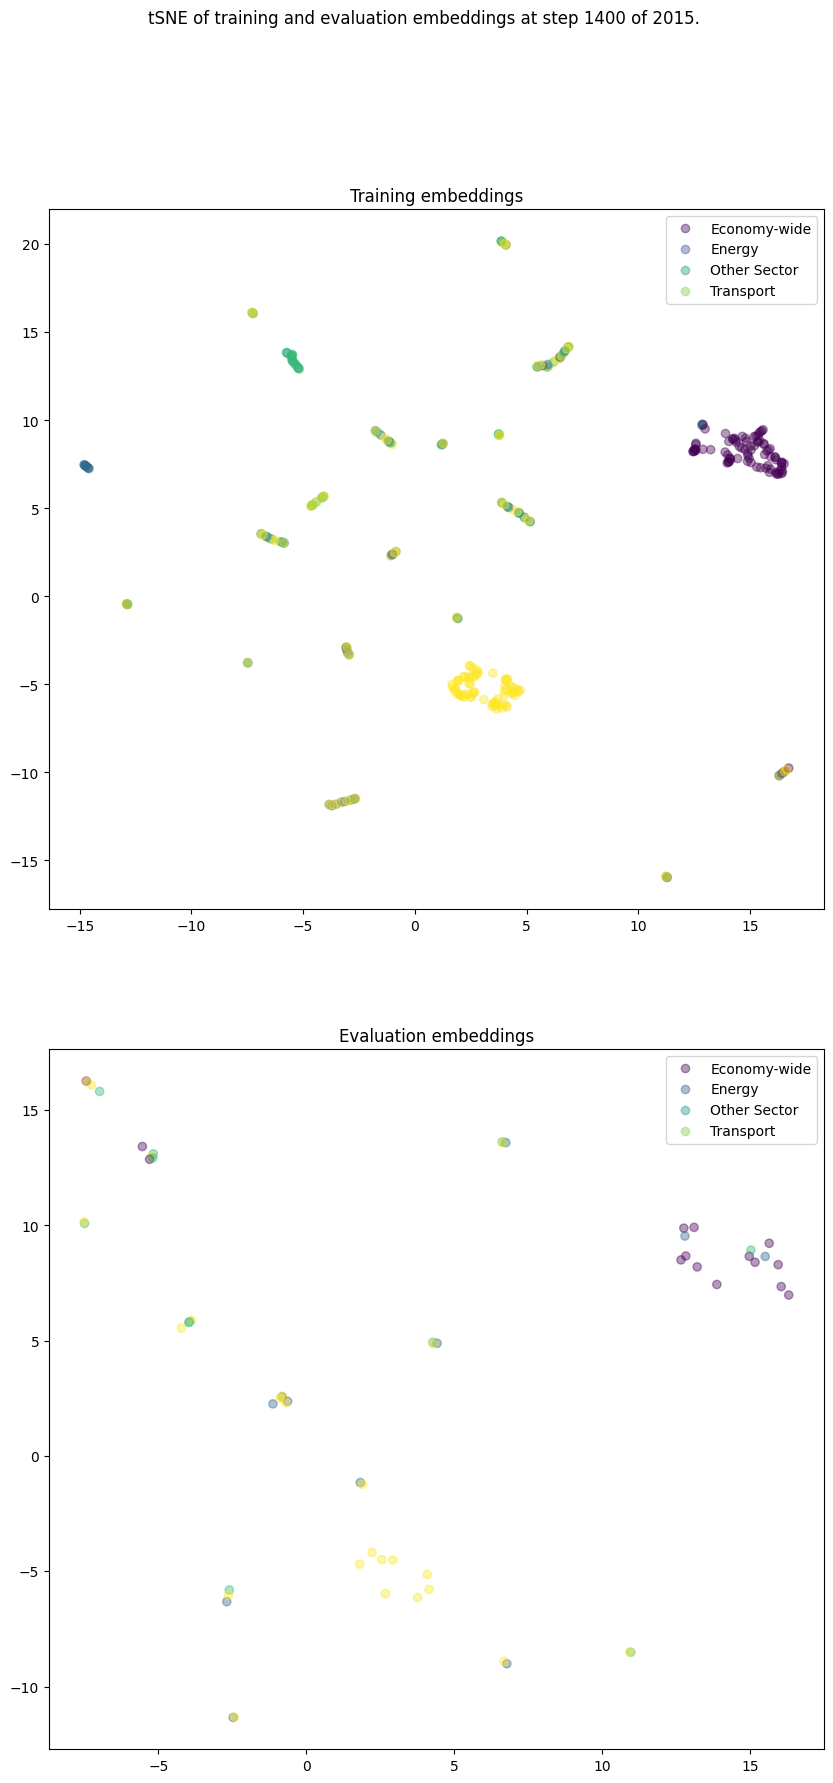

  0%|          | 0/59 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


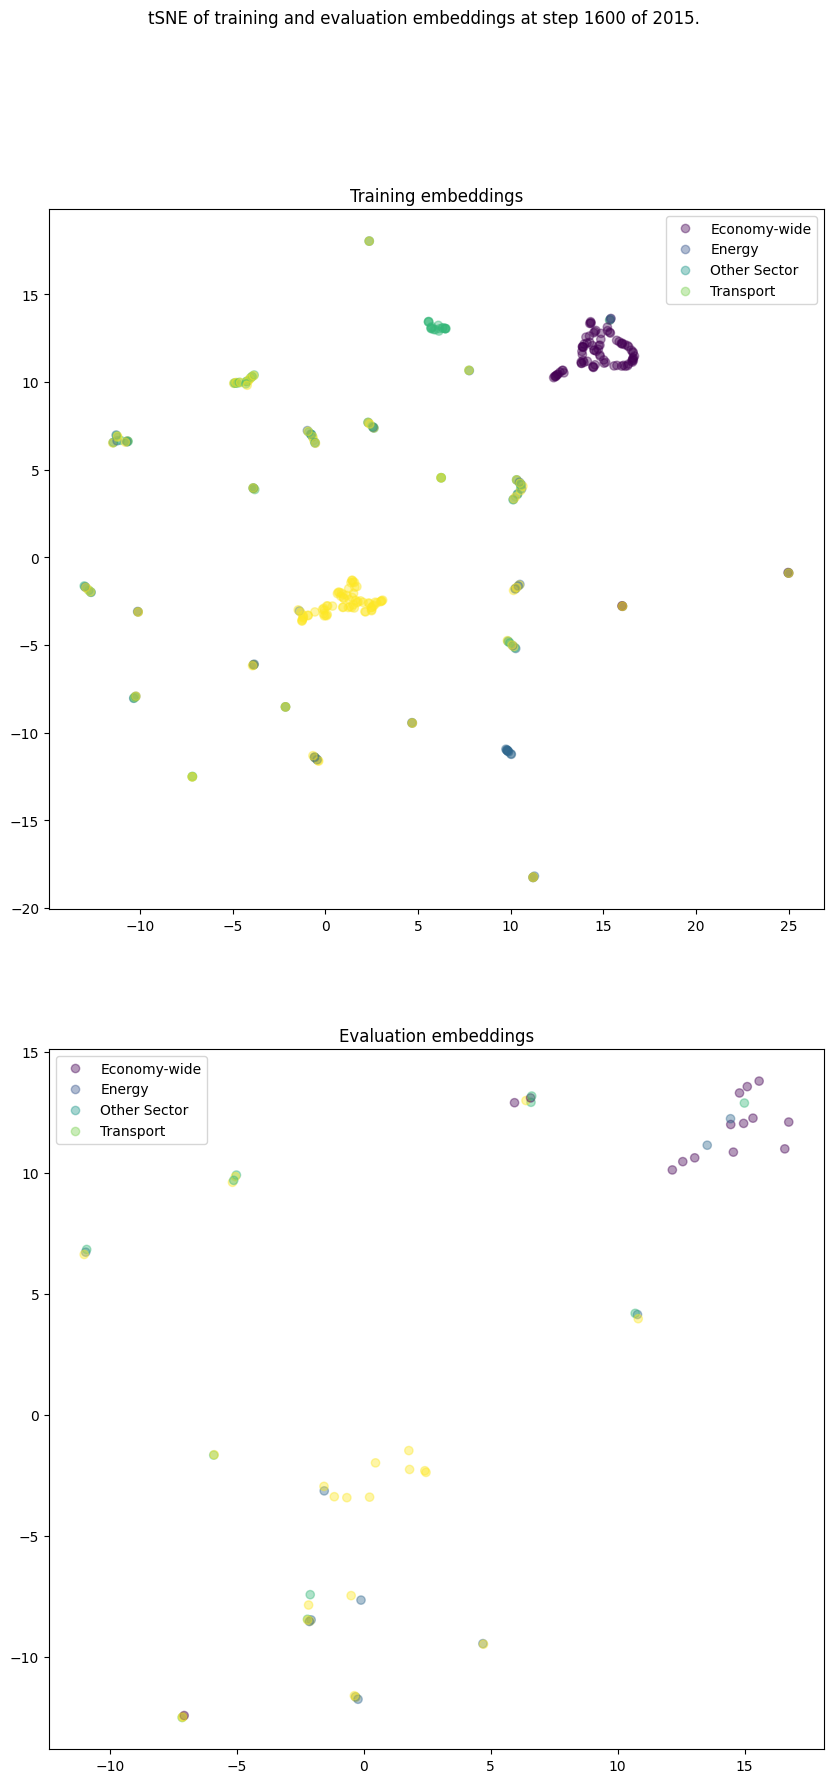

  0%|          | 0/59 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


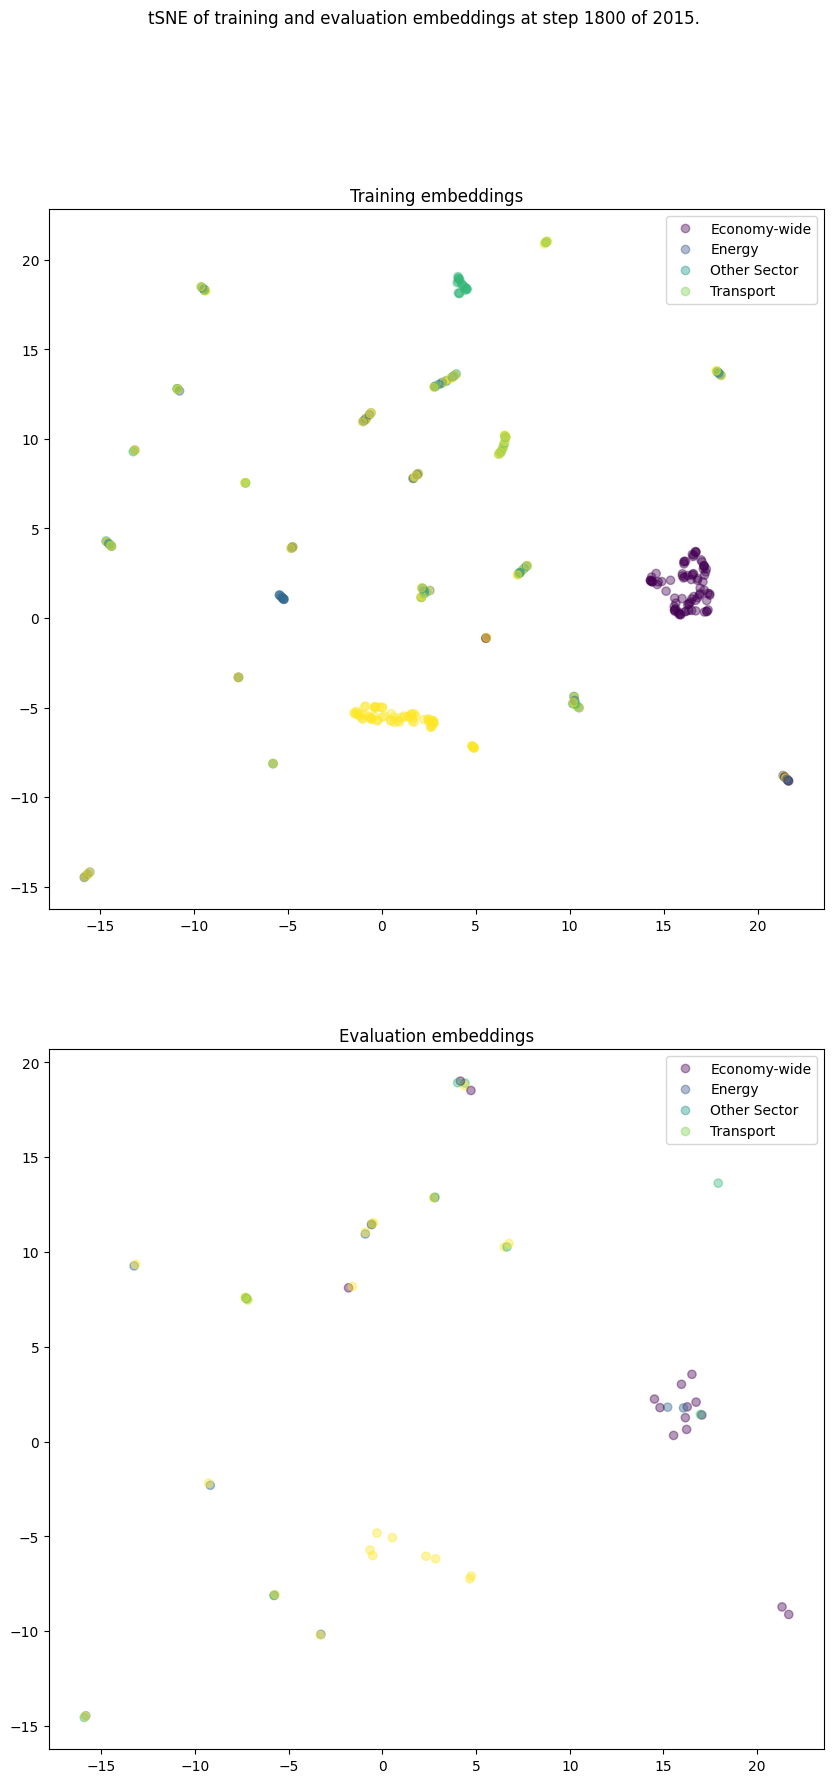

  0%|          | 0/59 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


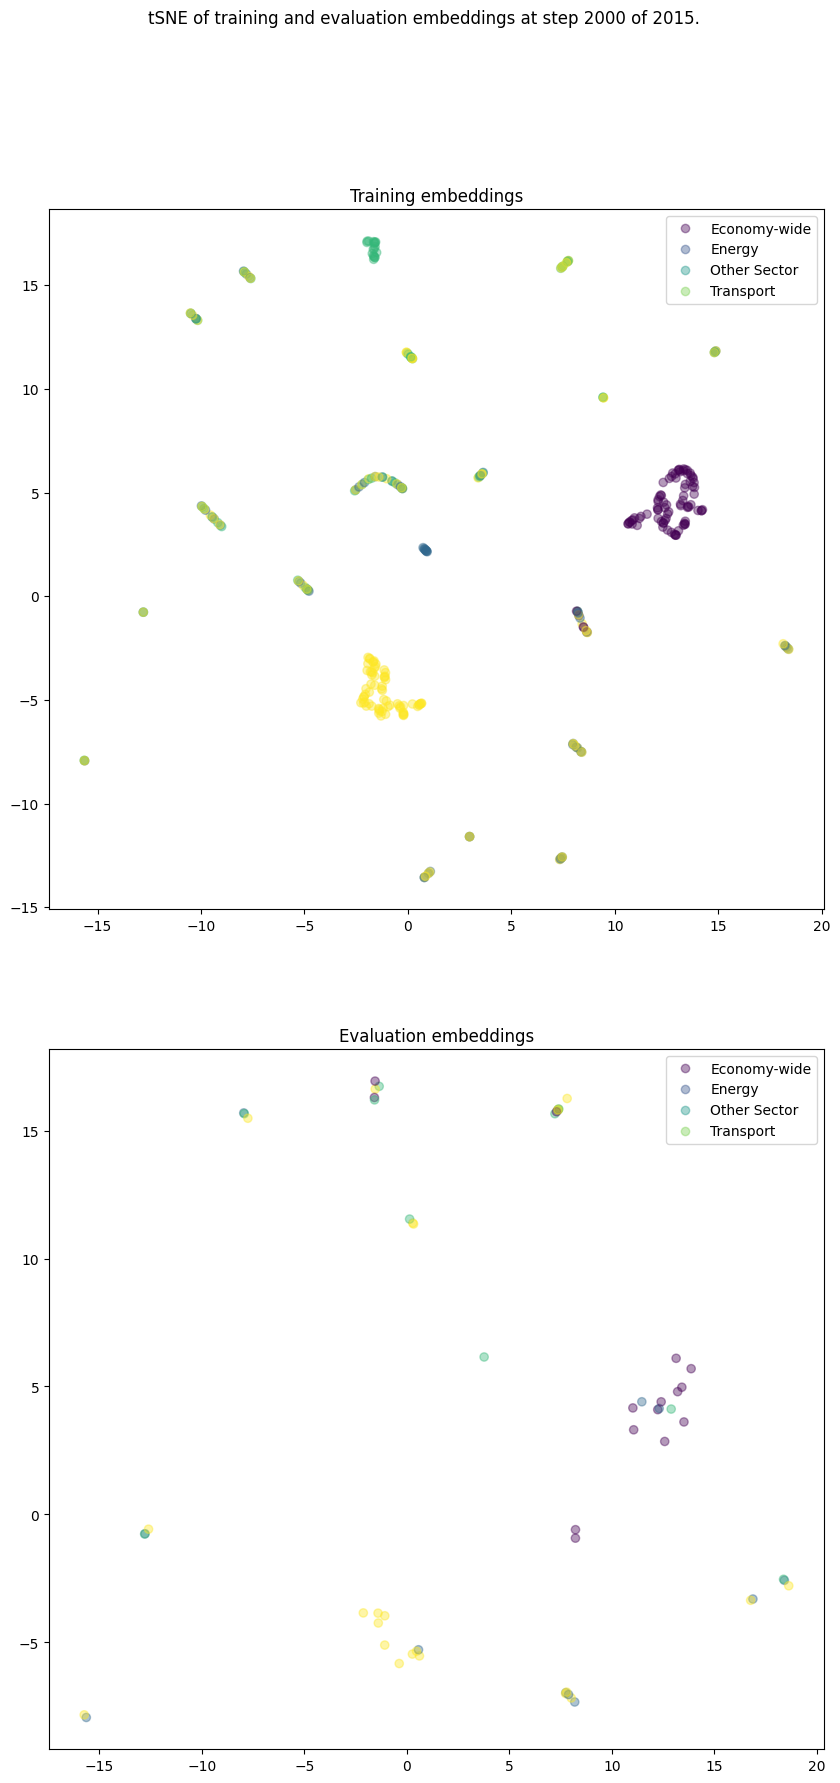

The `max_length` is `None`. Using the maximum acceptable length according to the current model body: 512.


Epoch: 0it [00:00, ?it/s]

In [ ]:
# if emebddings visulization are selected in callbacks then you can find the plots in
# folder "embeddings_plots" in root directory.
trainer.train()

In [ ]:
report = pd.DataFrame(trainer.model.model_card_data['eval_lines_list'])
report

,Epoch,Step,Training Loss,Validation Loss
0,0.000496,1,0.2029,-
1,0.099256,200,0.0111,0.1124
2,0.198511,400,0.0063,0.111
3,0.297767,600,0.0183,0.1214
4,0.397022,800,0.0197,0.1248
5,0.496278,1000,0.0387,0.1339
6,0.595533,1200,0.0026,0.1181
7,0.694789,1400,0.0378,0.1208
8,0.794045,1600,0.0285,0.1267
9,0.893300,1800,0.0129,0.1254


## Classifier Training

In [ ]:
import warnings
warnings.simplefilter('ignore')
trainer.train_classifier_new(list(df_train['text']),list(df_train['label']),list(df_test['text']),list(df_test['label']))

In [ ]:
metrics_training = pd.DataFrame(metrics['training'])
metrics_training = metrics_training.add_prefix('training_')
metrics_val = pd.DataFrame(metrics['validation'])
metrics_val  = metrics_val.add_prefix('val_')
metrics_df = pd.concat([metrics_training,metrics_val],axis=1)
display(metrics_df)
cols = list(metrics_df.columns)
cols_filtered = list(filter(lambda x: 'f1' in x, cols))
display(metrics_df[cols_filtered])

In [ ]:
trainer.push_to_hub("ppsingh/iki_sector_setfit")

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

model_head.pkl:   0%|          | 0.00/13.9k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/ppsingh/iki_sector_setfit/commit/9fd5038493527a5326d0673d13f15ff40eb60f2e', commit_message='Add SetFit model', commit_description='', oid='9fd5038493527a5326d0673d13f15ff40eb60f2e', pr_url=None, pr_revision=None, pr_num=None)

# Evaluate

In [ ]:
model = SetFitModel.from_pretrained("ppsingh/iki_sector_setfit")

config.json:   0%|          | 0.00/1.54k [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/123 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/9.04k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.63k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/964 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/270 [00:00<?, ?B/s]

config_setfit.json:   0%|          | 0.00/123 [00:00<?, ?B/s]

model_head.pkl:   0%|          | 0.00/13.9k [00:00<?, ?B/s]

In [ ]:
import sklearn.metrics as skm
# Run inference
y_pred = model(list(df_test.text))

y_pred = y_pred.tolist()
y_true = list(df_test.label)
cm = skm.multilabel_confusion_matrix(y_true, y_pred)
for i,label in enumerate(label_names):
    print(label)
    print(cm[i],'\n')

Economy-wide
[[25  2]
 [ 3 12]] 

Energy
[[31  0]
 [ 2  9]] 

Other Sector
[[26  5]
 [ 3  8]] 

Transport
[[17  1]
 [ 1 23]] 



In [ ]:
report = skm.classification_report(y_true, y_pred, output_dict=True)
df_report = pd.DataFrame(report).transpose()
df_report = df_report.reset_index()
mapping = {str(i):j for i,j in enumerate(label_names)}
df_report['index'] = df_report['index'].map(mapping).fillna(df_report['index'])
df_report.rename(columns = {'index':'label'}, inplace=True)
df_report

,label,precision,recall,f1-score,support
0,Economy-wide,0.857143,0.800000,0.827586,15.0
1,Energy,1.000000,0.818182,0.900000,11.0
2,Other Sector,0.615385,0.727273,0.666667,11.0
3,Transport,0.958333,0.958333,0.958333,24.0
4,micro avg,0.866667,0.852459,0.859504,61.0
5,macro avg,0.857715,0.825947,0.838147,61.0
6,weighted avg,0.879121,0.852459,0.863068,61.0
7,samples avg,0.869048,0.861111,0.848413,61.0
